In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
#import seaborn as sns
from sklearn.metrics import mean_squared_error

from keras.layers.advanced_activations import LeakyReLU
import os
from pandas import DataFrame
from numpy import concatenate

from sklearn.model_selection import GridSearchCV
import datetime
from math import sqrt
from keras import regularizers
import math
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

In [3]:
#**********Z score outlier detection*************************

def remove_outliers(data, threshold=5):
    mean= data.mean()
    std= data.std()
    idx= np.abs((data-mean)/std) <= threshold
    return data[idx].reshape(-1, 1)

In [4]:
#*******************************Load data***************************************

data_raw = []
for week in range(1, 10):
    week_data = pd.read_csv('../Paper1/usersout{}.csv'.format(week)).values
    data_raw.append(week_data)
    
data= np.array(data_raw)
dataset= np.concatenate(data)

In [5]:
#********Load data**************************

#dataset = pd.read_csv('spamkevin.csv', usecols=[0])
#dataset.dropna(0,inplace= True)
#dataset= np.array(dataset)
print('dataset with outlier', dataset.shape)
dataset= dataset.astype('float32')
dataset= remove_outliers(dataset)
print('dataset after removing outlier', dataset.shape)

# *****************split into train and test sets********************

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
data_train = dataset[0:train_size]
data_test = dataset[train_size:len(dataset)]
print('Data_train', data_train.shape, 'Data_test',data_test.shape)

# ********Normalize the data******************

scaler= MinMaxScaler (feature_range= (-1,1))
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)
print('Train_scaled',train_scaled.shape,' Test scaled', test_scaled.shape)

dataset with outlier (154583, 1)
dataset after removing outlier (154092, 1)
Data_train (123273, 1) Data_test (30819, 1)
Train_scaled (123273, 1)  Test scaled (30819, 1)


In [6]:
# ******************frame a sequence as a supervised learning problem*************

def prepare_seq2seq_data(dataset, look_back=1):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


look_back = 3
train_X, train_y = prepare_seq2seq_data(train_scaled , look_back)
test_X, test_y = prepare_seq2seq_data(test_scaled , look_back)

print('train_X',train_X.shape, 'train_y',train_y.shape)
print('test_X', test_X.shape, 'test_y',test_y.shape)

train_X (123269, 3) train_y (123269,)
test_X (30815, 3) test_y (30815,)


In [7]:
#*******Reshape from[samples, timesteps] into [samples, timesteps, features]*************

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
print('train_X',train_X.shape, 'train_y',train_y.shape)
print('test_X', test_X.shape, 'test_y',test_y.shape)

# convert 1 D to 2D array
#test_y = test_y.reshape((test_y.shape[0], 1))
#print(test_y.shape)

train_X (123269, 3, 1) train_y (123269,)
test_X (30815, 3, 1) test_y (30815,)


In [8]:
#**********RPE******************************
def rpe(y_true, y_pred):
    
    return backend.abs((y_pred - y_true)/y_true) * 100

In [9]:
#********************Build Model****************************

def build_model():
    
    model = tf.keras.models.Sequential()
    model.add(LSTM(128, input_shape=(look_back, 1),kernel_initializer='glorot_uniform',activation='relu'))
    #model.add(Dropout(0.1))
 
    model.add(Dense(1))
    model.summary()
    
     #optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer= 'adam', loss='mean_squared_error', metrics= [rpe])
    model.fit (train_X, train_y)
    
    return model


In [10]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [callback_early_stopping]

model =build_model()

history = model.fit(train_X, train_y, batch_size = 256,validation_split=0.2, epochs = 100, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm (UnifiedLSTM)   (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
123269/123269 [==============================] - 18s 144us/sample - loss: 0.0076 - rpe: 7.3789
Train on 98615 samples, validate on 24654 samples
Epoch 1/100
98615/98615 [==============================] - 4s 36us/sample - loss: 0.0062 - rpe: 6.8942 - val_loss: 7.1951e-14 - val_rpe: 5.8653e-05
Epoch 2/100
98615/98615 [==============================] - 3s 30us/sample - loss: 0.0062 - rpe: 7.2035 - val_loss: 1.5010e-13 - val_rpe: 8.4716e-05
Epoch 3/100
98615/98615 [==============================] - 3s 31us/sample

In [11]:
# **************************Model Performance Error  metrics*************************************

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,rpe,val_loss,val_rpe,epoch
70,0.005894,6.582207,7.993606e-15,0.000020,70
71,0.005896,6.571139,0.000000e+00,0.000000,71
72,0.005895,6.597759,1.421085e-14,0.000026,72
73,0.005906,6.607013,3.552714e-15,0.000013,73
74,0.005877,6.564080,3.552714e-15,0.000013,74


In [12]:
# convert 1 D to 2D array
train_y = train_y.reshape((train_y.shape[0], 1))
#print(test_y.shape)

# convert 1 D to 2D array
test_y = test_y.reshape((test_y.shape[0], 1))
#print(test_y.shape)

In [13]:
# *********************make predictions*************************************************************

trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

# *************************invert predictions**************************

trainPredict_inv = scaler.inverse_transform(trainPredict)
train_y_inv = scaler.inverse_transform(train_y)

testPredict_inv = scaler.inverse_transform(testPredict)
test_y_inv = scaler.inverse_transform(test_y)


# ********************RMSE*************************

trainScore = math.sqrt(mean_squared_error(train_y_inv, trainPredict_inv))
print('Train Score RMSE: %.2f ' % trainScore)
testScore = math.sqrt(mean_squared_error(test_y_inv, testPredict_inv))
print('Test Score RMSE: %.2f' % testScore)


Train Score RMSE: 175734.64 
Test Score RMSE: 172973.44


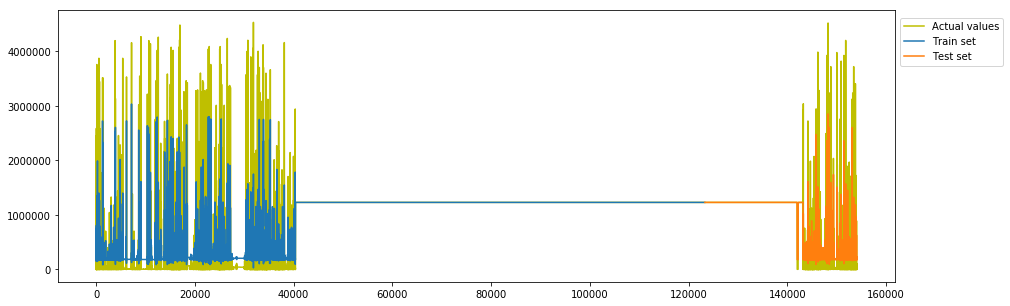

In [14]:
# ***********************shift train predictions for plotting*******************************

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict_inv
    
# **********************shift test predictions for plotting*************************************

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict_inv
    
# ********************Create the plot*************************************************************

plt.figure(figsize = (15, 5))
plt.plot(dataset, label= 'Actual values', color='y')
plt.plot(trainPredictPlot, label= 'Train set')
plt.plot(testPredictPlot, label= 'Test set')
plt.legend(bbox_to_anchor=(1, .99))
plt.show()


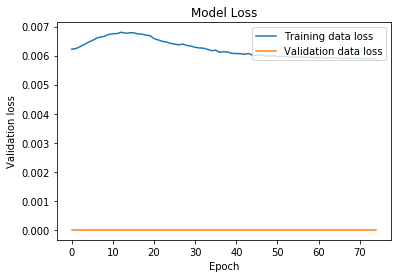

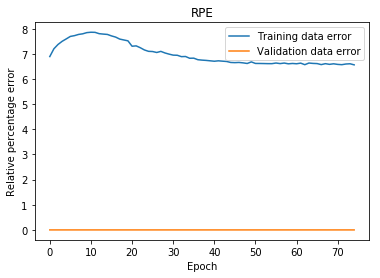

In [15]:
    
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Training data loss', 'Validation data loss'], loc='upper right')
plt.show()

 #***************************************RPE*****************************************
plt.figure()
plt.plot(history.history['rpe'])
plt.plot(history.history['val_rpe'])
plt.title('RPE')
plt.ylabel('Relative percentage error')
plt.xlabel('Epoch')
plt.legend(['Training data error', 'Validation data error'], loc='upper right')
plt.show()

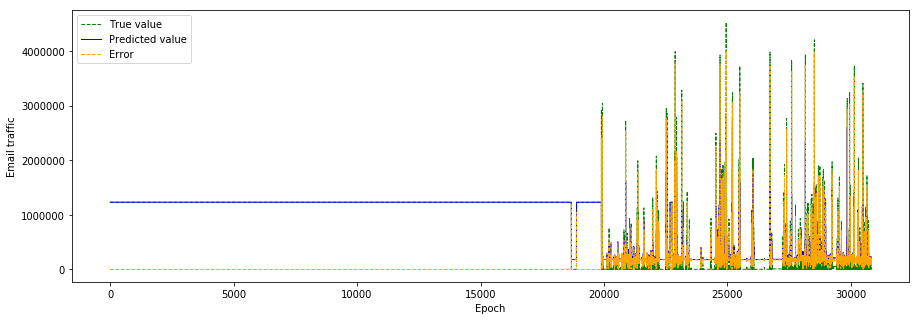

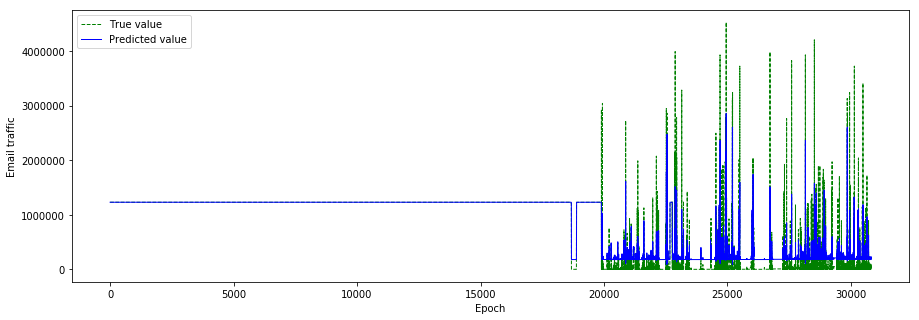

In [16]:
#********************* Actual value, Predicted value and Prediction Error ***************

plt.figure(figsize = (15, 5))
plt.xlabel("Epoch")
plt.ylabel("Email traffic")
plt.plot(test_y_inv[:,0], label="True value", linewidth=1,linestyle="--",color= 'green')
plt.plot(testPredict_inv[:,0], label="Predicted value", linewidth=1,color='blue')

error = abs(test_y_inv[:,0] - testPredict_inv[:,0])
plt.plot(error, label='Error',color= 'orange', linewidth=1, linestyle="--")
plt.legend()
plt.show()

#******************************* True value vs Prediction **********************/

plt.figure(figsize = (15, 5))
plt.xlabel("Epoch")
plt.ylabel("Email traffic")
plt.plot (test_y_inv[:,0], label="True value", linewidth=1,color= 'green', linestyle="--")
plt.plot(testPredict_inv[:,0], label="Predicted value", linewidth=1,color='blue')
plt.legend()
plt.show()

# Time Series Cross validation

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error, explained_variance_score

''' Estimator'''

estimator_LSTM = KerasRegressor(build_fn=build_model, verbose=1)

In [18]:
'''Cross Validate'''
#cv_scores = cross_val_score(estimator_rnn, train_X, train_y, cv=9)
#print(cv_scores.mean())

splits = TimeSeriesSplit(n_splits=10)

scores = cross_val_score(estimator_LSTM, train_X, train_y, cv=splits)
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))
print(scores.mean())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_1 (UnifiedLSTM) (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
11206/11206 [==============================] - 0s 31us/sample - loss: 0.0201 - rpe: 16.8189
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_2 (UnifiedLSTM) (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 

In [19]:
#******************RMSE Scores***************************************

mse_scores= -scores
mse_scores

#Convert to from mse to rmse
rmse_scores= np.sqrt(mse_scores)
print(rmse_scores)

#Calculate the average RMSE
print(rmse_scores.mean())
print(rmse_scores.std())

[0.14179826 0.12900817 0.11564628 0.01475135 0.00794607 0.01133528
 0.00782555 0.01428723 0.01155663 0.00335187]
0.04575066932313893
0.054783268288324596
